In [1]:
import os # Useful for running command line within python
import pandas as pd ## Useful for data manipulation

import torch ## Pytorch is the deep learning library that we will be using
import torch.nn as nn # Neural network module

import torchmetrics ## Torchmetrics is a library that contains metrics for evaluating models
from torch.utils.data import DataLoader

from torch.utils.data.dataset import Dataset

import pytorch_lightning as pl 
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from torchmetrics.regression import MeanSquaredError
from torchsummary import summary

from torch.nn import ReLU, Sequential
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
def transform_to_range(inputs,historic, y1=1,y0=-1):
    n_inputs=inputs.shape[1]
    names_inputs=historic.columns
    slope=torch.zeros(n_inputs)
    b_array=torch.zeros(n_inputs)
    for i in range(n_inputs):
        x1=historic[names_inputs[i+1]][1]
        x0=historic[names_inputs[i+1]][0]
        slope[i]=(y1-y0)/(x1-x0)
        b_array[i]=-x0*slope[i]+y0
                    
    return inputs*slope+b_array

def create_array_from_steps(tensor,step):
    l,n=tensor.shape
    new_tensor=torch.zeros((l-step+1,step,n))
    for i in range(l-step+1):
        new_tensor[i]=tensor[i:i+step]
        
    return new_tensor

Construct the training, validation and test set

In [3]:
## We are creating a custom dataset class
class WeatherData(Dataset):

    def __init__(self, csv_inputs, csv_outputs,csv_historic,step,y1=1,y0=-1):
        """
        Arguments:
            csv_inputs (string): Path to the csv file of the inputs of the NN.
            csv_outputs (string): Path to the csv file of temperatures 24 and 48 hours after measurement .
            csv_historic (string): Path to the csv file of historic weather data.
        """
        
        input_data = pd.read_csv(csv_inputs)
        output_data= pd.read_csv(csv_outputs)
        output_data=output_data["temperature_24"]
        historic= pd.read_csv(csv_historic)
        
        
        ## Transform input data
        n=len(input_data)
        minutes=[datetime.datetime.strptime(input_data["local_time"][i], '%Y-%m-%d %H:%M:%S').minute for i in range(n)]
        input_data["local_time"]=minutes
        inputs_tmp=transform_to_range(torch.tensor(input_data.values.astype(np.float32)),historic,y1=y1,y0=y0)
        self.inputs=create_array_from_steps(inputs_tmp,step)
        
        #Transform output data
        x1_temperature=historic["Air_Temperature_in_degrees_C"][1]
        x0_temperature=historic["Air_Temperature_in_degrees_C"][0]
        slope_temperature=(y1-y0)/(x1_temperature-x0_temperature)
        b_temperature=-x0_temperature*slope_temperature+y0
        outputs_tmp=torch.tensor(output_data.values.astype(np.float32))*slope_temperature+b_temperature
        self.outputs=outputs_tmp[step-1:]
        
    
        
        

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx:int):
        return self.inputs[idx],self.outputs[idx]

In [4]:
input_86077="./data/cleaned_data/86077_aws_plumber_data_inputs.csv"
output_86077="./data/cleaned_data/86077_aws_plumber_data_outputs.csv"
historic_path="./data/cleaned_data/Historical_data.csv"

In [5]:
dataset=WeatherData(input_86077,output_86077,historic_path,10)

In [9]:
dataset.inputs.shape

torch.Size([87465, 10, 11])

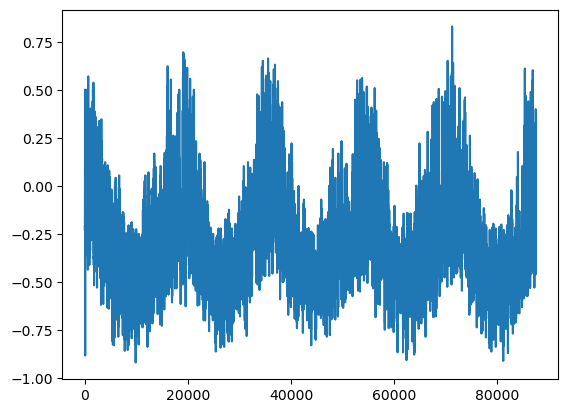

In [10]:
plt.plot(np.array(dataset[:][1]))

The data is order chronologically, so the division in terms of training, validation, and test should not be random. Instead, the data will be partition in 3 blocks. The blocks are ordered in chronological order. 

In [11]:
n_data=len(dataset)
split=[0.8,0.1,0.1]
n_train=int(np.floor(split[0]*n_data))
n_val=int(np.floor(split[1]*n_data))

trainset=torch.utils.data.Subset(dataset, range(n_train))
valset=torch.utils.data.Subset(dataset, range(n_train,n_train+n_val))
testset =torch.utils.data.Subset(dataset, range(n_train,n_data))

In [12]:
# Define a batch size of 16.
BATCH_SIZE = 64 #Just indicate the batch size

# Create Dataloaders 
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE)
valloader = DataLoader(valset, batch_size=BATCH_SIZE)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

I need to correct the WeatherLSTM class. Now the dataset have several time steps saved.

In [63]:
## We are going to use the PyTorch's nn.LSTM() method
class WeatherLSTM(pl.LightningModule):

    def __init__(self, n, learning_rate=1e-2, traindataloader=None, valdataloader=None, testdataloader=None): 
        
        super().__init__() # initialize an instance of the parent class, LightningModule.

        self.n=n
        self.lstm = nn.LSTM(input_size=11, hidden_size=1, batch_first=True) 
        ## The input size corresponds to the number of features of each measurement
        ## The hidden size gives the size of the output. In our case 2. The 24 and 48 temperature prediction
        
        # define learning rate
        self.learning_rate = learning_rate ## Just the numerical value of the learning rate

        # define loss function (Huber loss). This function is robust against outliers
        self.loss_fun = nn.HuberLoss() ## The function to calculate the loss
        
        # We calculate the mean square error as a perfomance metric
        
        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()
        self.test_mse = MeanSquaredError()
        
         # Define dataloaders
        self.traindataloader = traindataloader ### I am just passing the corresponding dataloader
        self.valdataloader = valdataloader   ### I am just passing the corresponding dataloader
        self.testdataloader = testdataloader ### I am just passing the corresponding dataloader
         

    def forward(self, x):
        x=x.view(len(x), self.n)
        x=torch.unsqueeze(x,0)
        lstm_out, temp = self.lstm(x)
        
        ## lstm_out has the short-term memories for all inputs. We make our prediction with the last one
        prediction = lstm_out[-1] 
        return prediction.reshape(len(prediction))
    
    def training_step(self, batch, batch_idx):

        # Make predictions
        x,y=batch ## The batch should come from the CovidDataset class
        # Do the prediction
        
        y_hat=self.forward(x) ## This predicts the results from x

        # Calculate the loss
        # Apply the loss function here
        loss=self.loss_fun(y_hat,y) ## Calculate the loss with the function declared in this class
        ## Update the MSE
        self.train_mse.update(y_hat, y)
        
        
        # Record accuracy and loss
        # Calling self.log will surface up scalars for you in TensorBoard
        # You may add more logs as you think necessary
         
        ### In the next two lines the history of the loss and accuracy is logged
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_mse", self.train_mse, prog_bar=True, on_step=False, on_epoch=True)

        # Return the loss
        return loss ## 

    def validation_step(self, batch, batch_idx):
        
        ### I am going to reuse the code for the training
        x,y=batch 
        y_hat=self.forward(x) ## This predicts the results from x

        # Compute loss for each batch
        loss=self.loss_fun(y_hat,y) ## Calculate the loss 
        ## Update the MSE
        self.val_mse.update(y_hat, y)


        # Record accuracy and loss
        # Log anything you think necessary
        ### Save the logs for the loss and for the accuracy
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_mse", self.val_mse, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        
        x,y=batch 
        y_hat=self.forward(x) ## This predicts the results from x

        # Compute loss for each batch
        loss=self.loss_fun(y_hat,y) ## Calculate the loss 

        self.test_mse.update(y_hat, y) 

        # Record accuracy and loss
        # Log anything you think necessary
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_mse", self.test_mse, prog_bar=True, on_step=False, on_epoch=True)

    def predict_step(self, batch, batch_idx):
        
        x,y=batch
        # Do prediction
        y_hat=self.forward(x)

        return y_hat,y,x # Return prediction, actual value and inputs  
        
        
    def configure_optimizers(self): 
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate) 

    
     ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        # return the train dataloader
        return  self.traindataloader ## Just return the traindataloader

    def val_dataloader(self):
        # return the validation dataloader
        return self.valdataloader  ### Just return the valdataloader

    def test_dataloader(self):
        # return the test dataloader
        return self.testdataloader  ## Just return the testdataloader

In [64]:
# Initialize the model by creating instance from Model class
lstm_model = WeatherLSTM(11, traindataloader=trainloader, valdataloader=valloader, testdataloader=testloader)

# Display a summary of the model's architecture
#summary(lstm_model, (1,11)) 

In [69]:
aa=torch.tensor([[1,2,3,4,5,6,7,8,9,10,11.0],[2.0,2.0,3,4,5,6,7,8,9,10,11.0],[2.0,2.0,3,4,5,8.0,7,8,9,10,11.0]])

In [70]:
aa=torch.unsqueeze(aa,0)

In [71]:
aa.shape

torch.Size([1, 3, 11])

In [133]:
test_lstm=nn.LSTM(input_size=11, hidden_size=1,  batch_first=True)

In [73]:
#aa=torch.tensor([[0.,1], [0.5,2]])
outputs,temp=test_lstm(aa)

In [75]:
outputs[-1]

tensor([[-9.3200e-07],
        [-2.9147e-06],
        [-3.7198e-06]], grad_fn=<SelectBackward0>)

In [140]:
fail_test=torch.tensor([[[340,2.0,3,43,5,6,7,8,9,10,11.0],[2.0,2.0,3,4,5,6,700,8,9,10,11.0],[2.0,2.0,3,4,5,8.0,7,8.1,9.8,10,11.0],
                        [2.0,2.0,3,4,5,8.0,7,8,9.8,10,11.0]],
                       [[1999,2,3,4,5,6,7,8,7,10,10.0],[2.0,2.0,3,4,5,6,7,8,9,10,11.0],[2.0,2.0,3,4,5,8.0,7,8.1,9.8,10,11.0],
                        [2.0,2.0,6,4,5,8.0,7,8,9.8,10,11.0]]
                       ])

In [141]:
fail_test.shape

torch.Size([2, 4, 11])

In [142]:
test_lstm(fail_test)

(tensor([[[0.0000e+00],
          [0.0000e+00],
          [3.6877e-07],
          [4.1088e-07]],
 
         [[0.0000e+00],
          [6.6146e-07],
          [3.8532e-07],
          [4.1103e-06]]], grad_fn=<TransposeBackward0>),
 (tensor([[[4.1088e-07],
           [4.1103e-06]]], grad_fn=<StackBackward0>),
  tensor([[[1.3423e-06],
           [7.0636e-06]]], grad_fn=<StackBackward0>)))

In [116]:
prediction, _=test_lstm(fail_test)

In [117]:
prediction[:,-1,:]

tensor([[5.4505e-13],
        [4.9901e-13]], grad_fn=<SliceBackward0>)

In [38]:
dataloader_iter=iter(trainloader)
data,label=next(dataloader_iter)
print("The shape of the batch is {}".format(data.shape))

The shape of the batch is torch.Size([64, 11])


In [60]:
aa=torch.tensor([[1],[2],[3]])

In [61]:
aa=aa.reshape(len(aa))

In [62]:
aa.shape

torch.Size([3])

In [36]:
lstm_model(aa).detach()

RuntimeError: shape '[1, 11]' is invalid for input of size 33

In [65]:
lstm_callback = ModelCheckpoint(
        monitor='val_mse',
        dirpath='.\\logs_lstm',
        save_top_k=1,
        mode='min',
        every_n_epochs=1)
# Monitor the validation mean square eror
# Specify a directory for checkpoints
# save the one best model
# Save the min. monitored quantity
# Monitor every 1 epoch


# Create a Trainer
n_epochs=100  ## I am defining the maximum number of epochs
lstm_trainer = pl.Trainer(accelerator = "auto",
                  max_epochs = n_epochs,
                  callbacks = [TQDMProgressBar(refresh_rate=20),lstm_callback],
                  logger = CSVLogger(save_dir=".\\logs_lstm"))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [66]:
lstm_trainer.fit(lstm_model)


  | Name      | Type             | Params
-----------------------------------------------
0 | lstm      | LSTM             | 56    
1 | loss_fun  | HuberLoss        | 0     
2 | train_mse | MeanSquaredError | 0     
3 | val_mse   | MeanSquaredError | 0     
4 | test_mse  | MeanSquaredError | 0     
-----------------------------------------------
56        Trainable params
0         Non-trainable params
56        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
